# Employee Attrition Analysis

In [7]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Preprocessing and Modeling
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    precision_recall_curve,
    roc_curve, 
    roc_auc_score
)

## 1. Data Loading and Initial Preprocessing

In [8]:
# Load dataset
df = pd.read_csv('data/IBM_HR_Analytics_Employee_Attrition.csv')

# Display basic information
print(df.info())

# Check missing values
print("\nMissing Values:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

## 2. Exploratory Data Analysis (EDA)

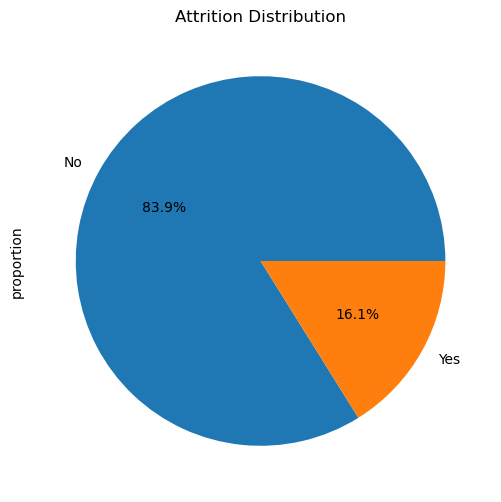

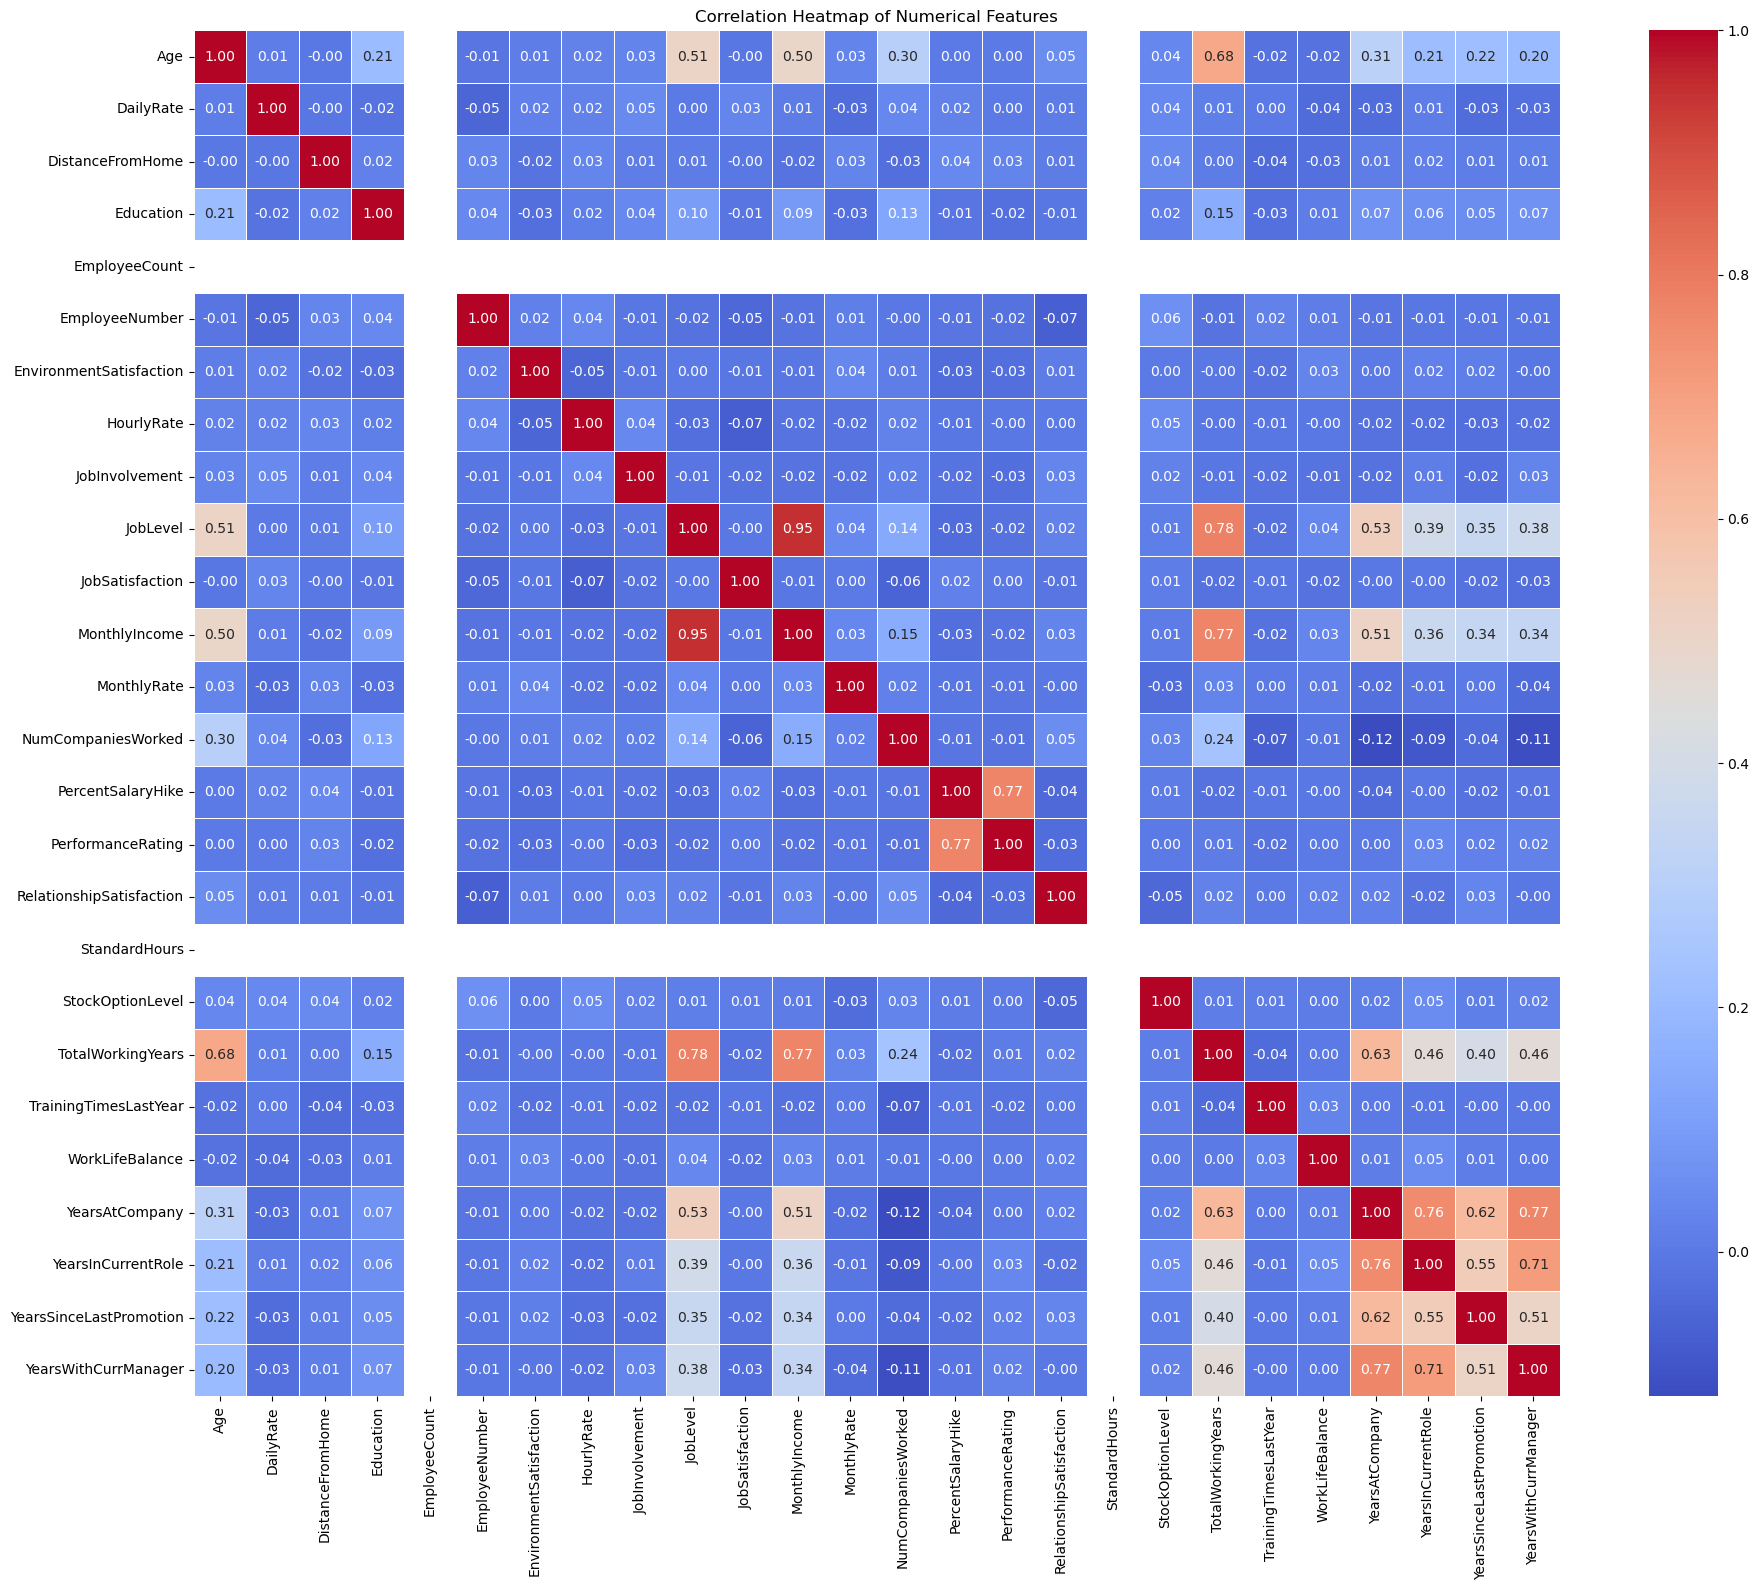

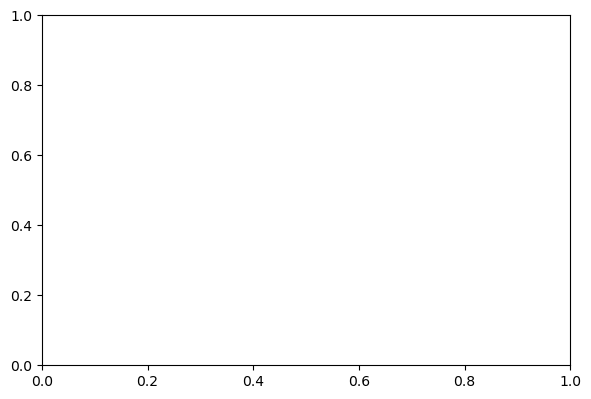

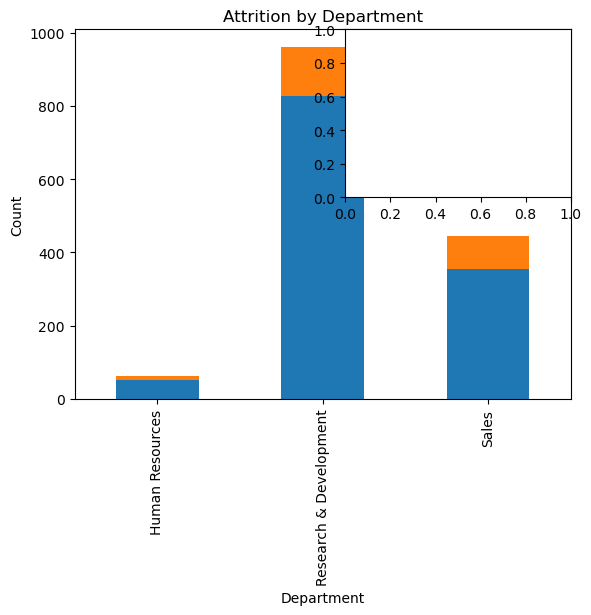

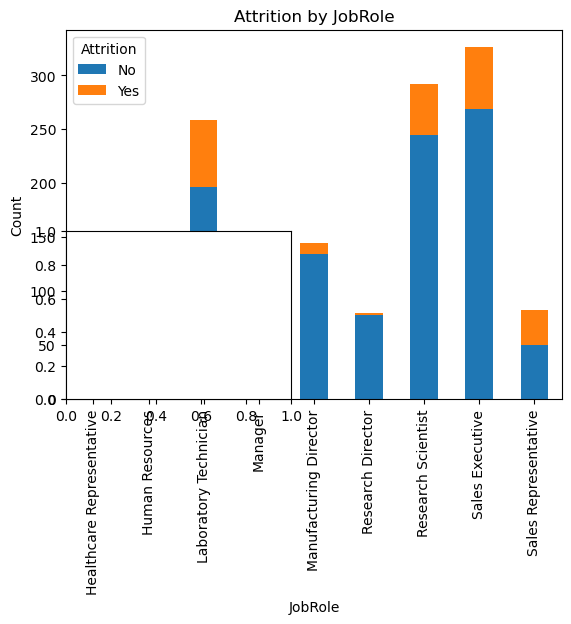

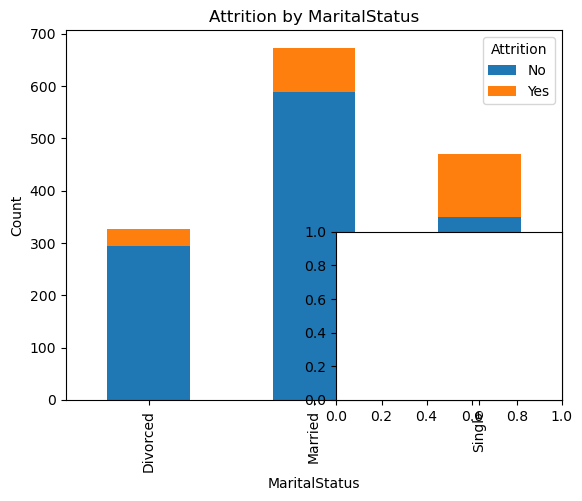

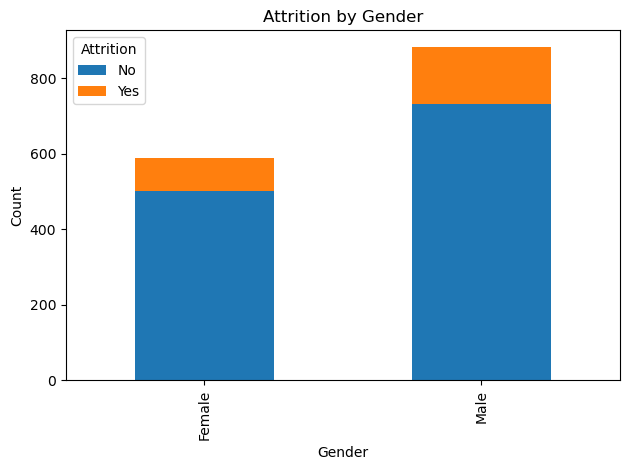

In [9]:
# Attrition distribution
plt.figure(figsize=(8, 6))
df['Attrition'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')
plt.title('Attrition Distribution')
plt.show()

# Correlation heatmap
plt.figure(figsize=(20, 16))
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', square=True)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

# Attrition by key categorical variables
categorical_vars = ['Department', 'JobRole', 'MaritalStatus', 'Gender']
plt.figure(figsize=(15, 10))
for i, var in enumerate(categorical_vars, 1):
    plt.subplot(2, 2, i)
    df.groupby([var, 'Attrition']).size().unstack().plot(kind='bar', stacked=True)
    plt.title(f'Attrition by {var}')
    plt.xlabel(var)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 3. Data Preprocessing for Modeling

In [10]:
# Preprocess target variable
df['Attrition'] = (df['Attrition'] == 'Yes').astype(int)

# Select features for modeling
features_to_use = [
    'Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 
    'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 
    'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 
    'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked', 'OverTime', 
    'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 
    'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 
    'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 
    'YearsSinceLastPromotion', 'YearsWithCurrManager'
]

X = df[features_to_use]
y = df['Attrition']

# Identify column types
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4. Model Training and Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       255
           1       0.57      0.10      0.17        39

    accuracy                           0.87       294
   macro avg       0.72      0.55      0.55       294
weighted avg       0.84      0.87      0.83       294



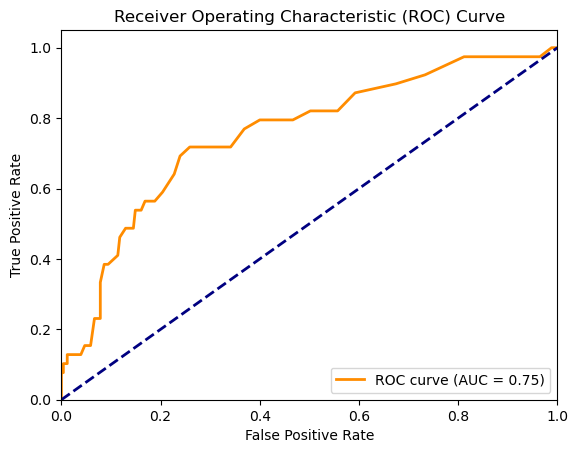

In [11]:
# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

# Model Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## 5. Feature Importance and Model Deployment

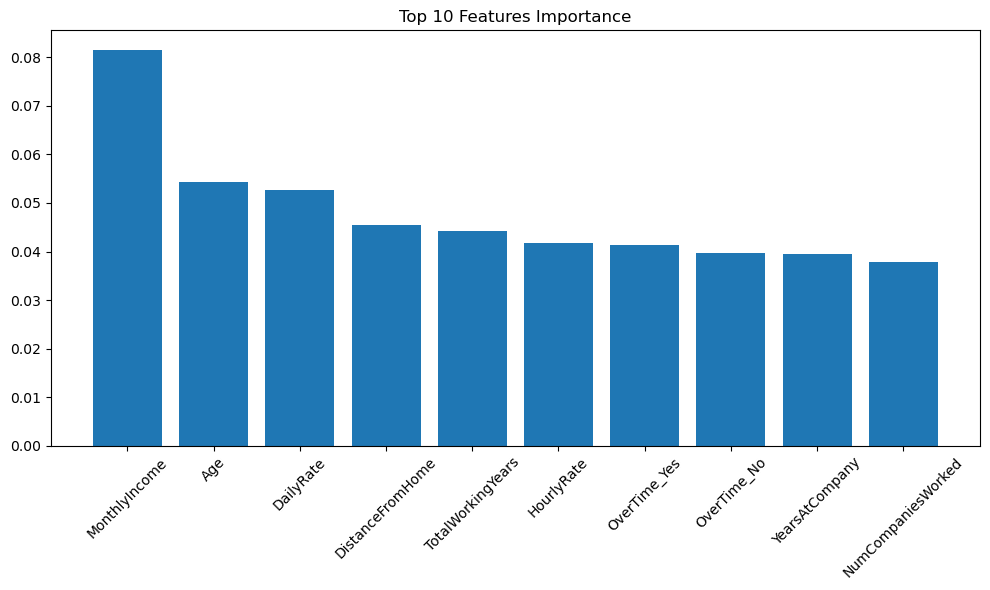

Model saved successfully!


In [12]:
# Extract feature names
feature_names = (list(numeric_features) + 
                 list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))

# Get feature importances
importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Top 10 Features Importance")
plt.bar(range(10), importances[indices][:10])
plt.xticks(range(10), [feature_names[i] for i in indices][:10], rotation=45)
plt.tight_layout()
plt.show()

# Save the model
joblib.dump(pipeline, 'employee_attrition_model.joblib')
print("Model saved successfully!")